In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*
plt.style.use('seaborn')
plt.rcParams.update(edog.plot.params)

filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])

A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
phase, damping, delay_g = itemgetter("phase", "damping", "delay")(params["ganglion"])

w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
tau_rg, delay_rg = itemgetter("tau", "delay")(params["relay"]["Krg"])

w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
tau_rig, delay_rig = itemgetter("tau", "delay")(params["relay"]["Krig"])

w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_mix"]["Krc_ex"])
tau_rc_ex, delay_rc_ex = itemgetter("tau", "delay")(params["relay"]["Krc_mix"]["Krc_ex"])

w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_mix"]["Krc_in"])
tau_rc_in, delay_rc_in = itemgetter("tau", "delay")(params["relay"]["Krc_mix"]["Krc_in"])

w_rc_mix = itemgetter("w")(params["relay"]["Krc_mix"])
delayed_in, delayed_ex = itemgetter("delayed_in", "delayed_ex")(params["relay"]["Krc_mix"])

irf_data = {}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Feedforward excitation

In [10]:
network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                        A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                        phase=phase, damping=damping, delay_g=delay_g,
                                        w_rg=w_rg, A_rg=A_rg, a_rg=a_rg, 
                                        tau_rg=tau_rg, delay_rg=delay_rg)

Nr = network.integrator.Nr
Nt = network.integrator.Nt

[relay] = get_neuron("Relay", network)
network.compute_irf(relay)

temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
t_peak, I_bp = temporal_irf_params(temporal_irf, network.integrator.times)

irf_data["ff_ex"] = {"irf": temporal_irf, "t_peak": t_peak, "I_bp": I_bp}

## Mixed feedback delays

In [11]:
t_peak = np.zeros([len(delay_rc_in), len(delay_rc_ex)]) * pq.ms
I_bp = np.zeros([len(delay_rc_in), len(delay_rc_ex)])
irf = np.zeros([Nt, len(delay_rc_in), len(delay_rc_ex)])

for i, delay_in in enumerate(delay_rc_in):
    for j, delay_ex in enumerate(delay_rc_ex):
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                                tau_rig=tau_rig, delay_rig=delay_rig,                                                
                                                w_rc_in=w_rc_in, A_rc_in=A_rc_in, a_rc_in=a_rc_in,
                                                tau_rc_in=tau_rc_in, delay_rc_in=delay_in,
                                                w_rc_ex=w_rc_ex, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                                tau_rc_ex=tau_rc_ex, delay_rc_ex=delay_ex)
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
        irf[:, i, j] = temporal_irf
        t_peak[i, j], I_bp[i, j] = temporal_irf_params(temporal_irf, network.integrator.times)
        

irf_data["mix"] = {"irf": irf, "t_peak": t_peak, "I_bp": I_bp}

## Delayed inhibition

In [12]:
irf = np.zeros([Nt, len(w_rc_mix)])

for i, w in enumerate(w_rc_mix): 
    network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                            A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                            phase=phase, damping=damping, delay_g=delay_g,
                                            w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                            tau_rg=tau_rg, delay_rg=delay_rg,
                                            w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                            tau_rig=tau_rig, delay_rig=delay_rig,                                            
                                            w_rc_in=w, A_rc_in=A_rc_in, a_rc_in=a_rc_in, 
                                            tau_rc_in=tau_rc_in, delay_rc_in=delayed_in["delay_in"],
                                            w_rc_ex=w, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                            tau_rc_ex=tau_rc_ex, delay_rc_ex=delayed_in["delay_ex"])

    [relay] = get_neuron("Relay", network)
    network.compute_irf(relay)
    temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
    irf[:, i] = temporal_irf

irf_data["delayed_in"] = irf

## Delayed excitation

In [13]:
irf = np.zeros([Nt, len(w_rc_mix)])

for i, w in enumerate(w_rc_mix): 
    network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                            A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                            phase=phase, damping=damping, delay_g=delay_g,
                                            w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                            tau_rg=tau_rg, delay_rg=delay_rg,
                                            w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                            tau_rig=tau_rig, delay_rig=delay_rig,  
                                            w_rc_in=w, A_rc_in=A_rc_in, a_rc_in=a_rc_in, 
                                            tau_rc_in=tau_rc_in, delay_rc_in=delayed_ex["delay_in"],
                                            w_rc_ex=w, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                            tau_rc_ex=tau_rc_ex, delay_rc_ex=delayed_ex["delay_ex"])

    [relay] = get_neuron("Relay", network)
    network.compute_irf(relay)
    temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
    irf[:, i] = temporal_irf
    
irf_data["delayed_ex"] = irf

-------------
## Plotting

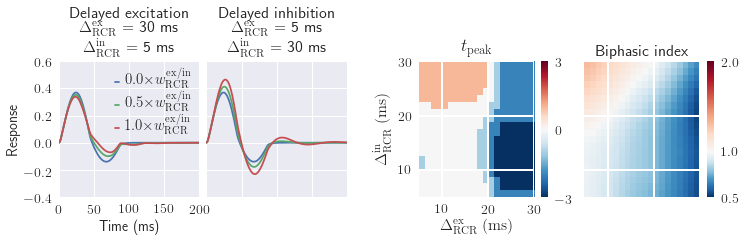

In [24]:
cmap = "RdBu_r"
interpolation = "none"
color = "gray"
alpha = 0.6

# line plots:
t_max = 200
ymin = -0.3
ymax = 0.5
yticks = [-0.4, -0.2, 0.0, 0.2, 0.4, 0.6]
xticks = [0, 50, 100, 150, 200]
times = network.integrator.times
w_ids = [0, int(np.where(w_rc_mix==0.5)[0]), int(np.where(w_rc_mix==1.0)[0])]


# imshow plots:
t_peak_vmin = -3
t_peak_vmax = 3

I_bp_vmin = 0.5
I_bp_vmax = 2.0

extent = [float(delay_rc_ex.min().magnitude), float(delay_rc_ex.max().magnitude), 
          float(delay_rc_in.min().magnitude), float(delay_rc_in.max().magnitude)]

# figure grid
fig = plt.figure(figsize=(10, 2.5))

# line plots
gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.05, right=0.45, hspace=5, wspace=0.05)
ax1 = plt.subplot(gs1[:2, 0])
ax2 = plt.subplot(gs1[:2, 1])

# imshow plots
gs2 = gridspec.GridSpec(2, 2)
gs2.update(left=0.55, right=0.98, hspace=5, wspace=0.15)
ax3 = plt.subplot(gs2[:2, 0])
ax4 = plt.subplot(gs2[:2, 1])


#########################################################################################################################
# create figure
#########################################################################################################################

# lineplots
for ax, data in zip([ax1, ax2], [irf_data["delayed_ex"], irf_data["delayed_in"]]):
    ax.set_ylim([ymin, ymax])
    ax.set_xlim([0, t_max])
    ax.set_yticks(yticks)
    ax.set_xticks(xticks)
    for w_id in w_ids:
        ax.plot(times, data[:, w_id], label=r"${} \times$".format(w_rc_mix[w_id])+r"$w_\mathrm{RCR}^\mathrm{ex/in}$")

        
ax1.legend(fontsize=15, handlelength=0.3, labelspacing=0.2, borderpad=0.3, 
           borderaxespad=0.3, handletextpad=0.4, loc="upper right")
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Response")
ax2.set_title("Delayed inhibition \n {} = {} \n {} = {}".format(r"$\Delta_\mathrm{RCR}^\mathrm{ex}$", delayed_in["delay_ex"], 
                                                                r"$\Delta_\mathrm{RCR}^\mathrm{in}$", delayed_in["delay_in"]))
ax1.set_title("Delayed excitation \n {} = {} \n {} = {}".format(r"$\Delta_\mathrm{RCR}^\mathrm{ex}$", delayed_ex["delay_ex"], 
                                                                r"$\Delta_\mathrm{RCR}^\mathrm{in}$", delayed_ex["delay_in"]))

# t_peak plot
t_peak = (irf_data["mix"]["t_peak"].rescale("ms") - irf_data["ff_ex"]["t_peak"]).magnitude
im1 = ax3.imshow(t_peak, aspect="auto", origin="lower", cmap=cmap, extent=extent, 
                 interpolation=interpolation, vmin=t_peak_vmin, vmax=t_peak_vmax, 
                 norm=MidpointNormalize(midpoint=0.))

plt.colorbar(im1, ax=ax3, ticks=[t_peak_vmin, 0, t_peak_vmax])
ax3.grid(color="w", lw=2)   

# Biphasic index plot
I_bp = irf_data["mix"]["I_bp"] / irf_data["ff_ex"]["I_bp"]
im2 = ax4.imshow(I_bp, aspect="auto", origin="lower", cmap=cmap, extent=extent, 
                 interpolation=interpolation, vmin=I_bp_vmin, vmax=I_bp_vmax, 
                 norm=MidpointNormalize(midpoint=1.))

plt.colorbar(im2, ax=ax4, ticks=[I_bp_vmin, 1, I_bp_vmax])
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.grid(color="w", lw=2)    


ax3.set_title(r"$t_\mathrm{peak}$", fontsize=18)
ax4.set_title("Biphasic index")
ax3.set_ylabel(r"$\Delta_\mathrm{RCR}^\mathrm{in}\; (\mathrm{ms})$", fontsize=16)
ax3.set_xlabel(r"$\Delta_\mathrm{RCR}^\mathrm{ex}\; (\mathrm{ms})$", fontsize=16)